# <center> Page Rank </center>
## <center> Teleporting </center>
## <center> 3$^{rd}$ Assignment - 3$^{rd}$ Notebook </center>
### <center> By Group 80 for the course Advances in Data Mining of the University of Leiden taught by Wojtek Kowalczyk </center>
<center> Lisa Dombrovskij (s1504819) - dombrovskij@strw.leidenuniv.nl </center>
<center> Margherita Grespan (s2233150) - grespan@strw.leidenuniv.nl </center>

***

This notebook is a continuation of two other notebooks; 'prep' and 'eda' respectively. For further introduction and explanation please look at those notebooks.

In this notebook we will explore a method to find the principal eigen vector of transition matrix M. This method is used to avoid spider traps and dead ends. Spider traps can consist of a node or multiple nodes. If it consists of a single node, a spider trap means that the node links to itself and one can thus get stuck there. If it consists of multiple nodes it can also mean that one can get stuck going in a circle, through the same nodes. In order to avoid getting trapped, one can use the method of *teleporting*. This means that with probability $\beta (0 < \beta <= 1)$ we continue the random walk through the nodes and with probability $1-\beta$ we jump to any other node.

Eventually the goal is to rank the pages. For this, an algorithm called PageRank is used. This algorithm is used by Google to rank their webpages for the search engine. 

In this notebook we will use the clasical update rule, before implementing the full PageRank algorithm in the next notebook.
Having  $\vec v'$ as the new estimate, $\vec v$ the current one and M transition matrix between the nodes:

$v'=\beta \cdot M \cdot v + (1- \beta)\cdot \frac{\vec e}{n} $

$\beta$ is a constant, usually 0.8 or 0.9, $\vec e$ is a unit vector and n the amount of nodes represented by the transition matrix.

This equation includes the possibility to continue surfing along links at random (the random walk): $\cdot M \cdot v$. Basically, this means the visitor will follow an outgoing edge from the present page. The second term express the chance - 10% with $beta$=0.9 - of visiting a completely new web-page.

In [85]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from scipy.sparse import csc_matrix, diags
import random 
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
np.warnings.filterwarnings('ignore')

In [86]:
with open('prepared_data', 'rb') as f:
    data = pickle.load(f)
print('** Read prepared data **')

** Read prepared data **


In [87]:
n_nodes = len(pd.unique(data[['new_page_id_from', 'new_page_id_to']].values.ravel('K')))
print('The amount of nodes is: ', n_nodes)

The amount of nodes is:  248193


In order to create the transition matrix, we need to calculate the probabilities of transitioning from one node to the other. For this, we first count the number of outgoing edges for each node.

In [88]:
#counting the num. of connections
temp = pd.DataFrame({'page_id':np.arange(n_nodes)})
n_outgoing_count = data.groupby('new_page_id_from').size().reset_index(name = 'n_outgoing')
n_outgoing = pd.merge(temp, n_outgoing_count, left_on = 'page_id', right_on = 'new_page_id_from', how='outer').fillna(0)
n_outgoing.drop(columns = ['new_page_id_from'], inplace=True)

In [89]:
print('Table that shows the amount of outgoing links per each page')
n_outgoing.head()

Table that shows the amount of outgoing links per each page


,page_id,n_outgoing
0,0,193.0
1,1,21.0
2,2,22.0
3,3,61.0
4,4,47.0


The table above shows the number of outgoing edges for each page_id. Using this and the data we can now create the transition matrix. The transition matrix will be a sparse matrix. A sparse matrix only stores the non-zero elements, the zero elements are ignored. This saves a lot of storage space (as most pages are linked to a small amount of pages, so the number of zeros in the transition matrix will be large) and will speed up the algorithm.

In [90]:
#Create the transition matrix
m_ones=np.ones(data.shape[0]) #Make ones for links
M=csc_matrix(( m_ones, (data.new_page_id_to.values,data.new_page_id_from.values))) #Create sparse matrix
prob=1/n_outgoing.n_outgoing.values #Calculate probabilities
prob=diags(prob) 
M=np.dot(M,prob)
print('** transition matrix done **')
v_sparse=csc_matrix(np.zeros((n_nodes)))

** transition matrix done **


Below the first five rows of the first five columns of the transition matrix are shown as an example. It is clear that there will be a lot of zero entries in the matrix, and thus using a sparse matrix is useful.

We perform a quick check to see whether the transition matrix is correct:
- The only non-zero element is in position (1,1).
- From the data we know that tpage 1 has 21 outgoing links. Thus, the value shown in the transition matrix is $\frac{1}{21}$.

In [91]:
print(' ** Transition matrix ** ')
M_d=pd.DataFrame(M[0:5,0:5].todense())
display(M_d)
print('** Table containing links from page 1 **')
display(data.loc[(data.new_page_id_from == 1)].head())
print('** Table containing the amount of ougoing links per page **')
display(n_outgoing.head())

 ** Transition matrix ** 


,0,1,2,3,4
0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.047619,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0


** Table containing links from page 1 **


,new_page_id_from,new_page_id_to
193,1,1
194,1,163504
195,1,1688
196,1,107315
197,1,4265


** Table containing the amount of ougoing links per page **


,page_id,n_outgoing
0,0,193.0
1,1,21.0
2,2,22.0
3,3,61.0
4,4,47.0


As explained in the 2$^{nd}$ Notebook of this project, 'eda', the sequence v, Mv, M(Mv), ...  should converge to v' such that v' is the principal eigen vector of matrix M. In order to check the convergence we calculate for 25 iterations the value of $\vec v$ and the relative *MSE* (mean squared error):

$MSE=\frac{1}{n}\sum_{1=1}^{n}(M_{ji}\cdot v_i - v_i)^2 $

We also remind here the v' equation:
$v'=\beta \cdot M \cdot v + (1- \beta)\cdot \frac{\vec e}{n} $

In [92]:
MSE=[] #Empty list to store MSE values
e=csc_matrix(np.ones((n_nodes)))/n_nodes #Create e unit vector
number_of_steps = 25 #number of iterations over update rule
beta=.8
beta_minus_one = 1-beta #Probability to teleport

for i in range(number_of_steps):
        a=v_sparse.dot(M) #Calculate new v
        v_sparse=beta*a+beta_minus_one*e #Use the update rule and set v to the new vector
        MSE.append(mean_squared_error(a.toarray(),v_sparse.toarray()))

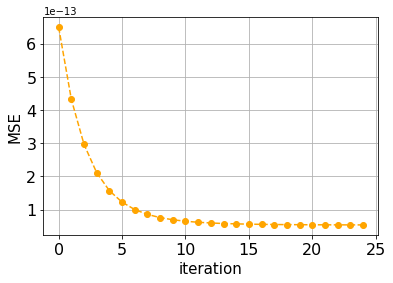

In [93]:
plt.plot(MSE, color='orange', linestyle='--', marker='o')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

In [94]:
print("MSE after 25 iterations: {}".format(MSE[-1]))

MSE after 25 iterations: 5.357283570632631e-14


After iterating 25 times over the update rule, we can plot the MSE after each iteration. We see that it converges somewhere between 10 and 15 iterations to $5.36 * 10^{-14}$.

### Number of Nodes Estimation

Imagine that our computer has 1GB RAM and the average out-degree of graph G is 15. What is the maximal number of nodes of G such that this algorithm could be executed on our computer?

Say we have the transition matrix M as a sparse matrix and v as a full vector. This means that the total number of (non-zero) elements in the sparse matrix is equal to the number of links and the total number of elements in v is equal to the total number of nodes. If we store every number with double precision, each element will be 64 bits. We also know that $1 bit = 1.25 * 10^{-10} GB$. 
This means that

$totalGB = \#elements * 64 * 1.25 * 10^{-10}$.

Then the total amount of elements we could store in 1GB RAM would be

$ \#elements = \frac{1GB}{64*1.25*10^{-10}} =  125000000$.

If our graph has an average out-degree of 15, then each column of the transition matrix M will contain 15 elements on average. We can then write the following equation:

$(125000000 - n_{nodes}) / 15 = n_{nodes}$.

We can rewrite this as

$\frac{125000000}{n_{nodes}} = 16$

so then

$n_{nodes} = \frac{125000000}{16} = 7812500$